### Hard Margin Support Vector Machine

Implement a Support Vector Machine (SVM) for binary classification using the dual formulation of the hard-margin SVM problem, and apply it to the Iris dataset. 

The dual form of the hard-margin SVM problem is:

$$
\max_{\lambda} \left( \sum_{i=1}^{n} \lambda_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \lambda_i \lambda_j y_i y_j \langle x_i, x_j \rangle \right),
$$

subject to:

$$
\lambda_i \geq 0 \;\ \forall i, \quad \text{and} \;\ \sum_{i=1}^{n} \lambda_i y_i = 0,
$$

where $\lambda_i$ are the Lagrange multipliers, $y_i$ are the true labels, $x_i$ are the feature vectors, and $\langle x_i, x_j \rangle$ is the inner product between feature vectors $x_i$ and $x_j$.

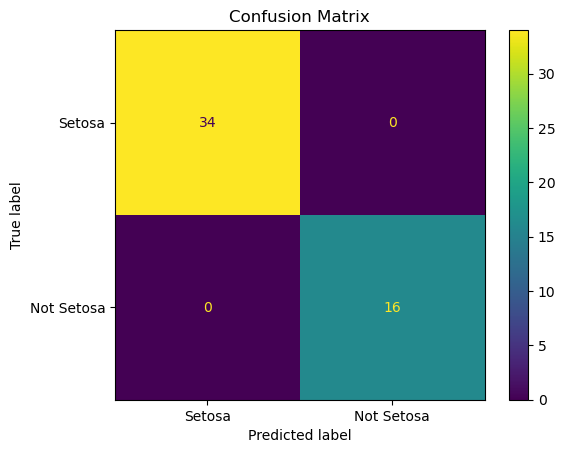

AUC Score: 1.00


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
import cvxpy as cp

data = pd.read_csv('iris.csv')

# Filter data into two classes
data['variety'] = data['variety'].apply(lambda x : 1 if x == 'Setosa' else -1)

# Randomly sort data points into training and testing sets
training_set, testing_set = train_test_split(data, test_size=0.33)
training_set = training_set.to_numpy()
testing_set = testing_set.to_numpy()

n = training_set.shape[0]
y = training_set[:, -1]
x = training_set[:,:-1]
epsilon = 1e-6

# Define the variables
lmb = cp.Variable(n)  

# Define the objective function
inner_prod = np.dot(x, x.T) + epsilon * np.eye(n)
quad_terms = cp.quad_form(cp.multiply(y, lmb), inner_prod)
objective = cp.Maximize(cp.sum(lmb) - 0.5 * quad_terms)

# Define the constraints
constraints = [ lmb >= 0, cp.sum(cp.multiply(lmb, y)) == 0 ]

#Solve the problem
problem = cp.Problem(objective, constraints) 
problem.solve()

# Derive support vectors
sv_indices = np.where(lmb.value > epsilon)[0]

# Compute w, b and predicted values
w = np.sum([lmb.value[i] * y[i] * x[i,:] for i in sv_indices], axis=0)
b = 1 / sv_indices.size * np.sum([y[i] - np.dot(w, x[i,:]) for i in sv_indices])

# Generate and plot confusion matrix
test_feat = testing_set[:, :-1]
test_label = testing_set[:, -1]

# Compute predictions using w, b
pred_label = np.zeros_like(test_label)
for i in range(test_label.size):
    y_hat = np.dot(w,test_feat[i, :]) + b
    pred_label[i] = -1 if y_hat <= 0 else 1

# Compute and plot confusion matrix
cm = confusion_matrix(test_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Setosa', 'Not Setosa'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Compute ROC AUC score
roc_auc = roc_auc_score(test_label, pred_label)

print(f"AUC Score: {roc_auc:.2f}")

## **Feature Embeddings and the Kernel Trick**

The dataset below is characterized by two classes, wherein one is nested within the other. This is a classic example of non-linearly separable data in the original feature space.

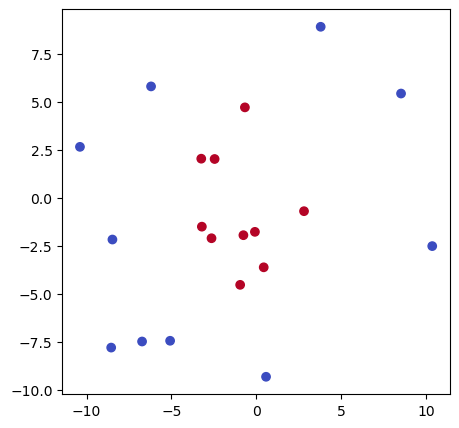

In [ ]:
np.random.seed(42)
def generate_nested_hyperspheres(n_samples_per_class, n_features, r1 = 0.1, r2 = .3):
    data_xs1 = np.random.normal( size = (n_samples_per_class, n_features) )
    data_xs1 /= np.linalg.norm(data_xs1, axis=1,keepdims = True) * r1
    data_xs2 = np.random.normal( size = (n_samples_per_class, n_features) )
    data_xs2 /= np.linalg.norm(data_xs2, axis = 1,keepdims = True) * r2

    # Stack classes and create labels
    data_xs = np.concatenate([data_xs1,data_xs2],axis=0)
    data_xs += np.random.normal( scale = 1., size = data_xs.shape)
    label_ys = np.concatenate([np.ones(n_samples_per_class)*i for i in [-1,1] ])
    return data_xs, label_ys

data_xs,label_ys = generate_nested_hyperspheres( n_samples_per_class = 10, n_features = 2 )
fig,ax = plt.subplots(1,1,figsize=(5.,5.))
ax.scatter(data_xs[:,0],data_xs[:,1],c=label_ys,cmap='coolwarm')
plt.show()

I design a feature embedding to transforms the original features into a new space where the classes are linearly separable. The kernel function `kernel(data_xs)` computes the similarity between data points.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
def feature_map(data_xs):
    poly = PolynomialFeatures(degree=2)
    return poly.fit_transform(data_xs)
    
# return Gram-matrix
# k(x,x') = <x.s + 1>^2
def kernel(X):
    M = np.dot(data_xs, data_xs.T)
    return (M+1)*(M+1)

We know that a symmetric function $k(x, x^\prime)$ is a kernel if and only if there exists an embedding such that $k(x, x^\prime) = \langle \phi(x), \phi(x^\prime) \rangle$. We have $k(x, x^\prime) = (x \cdot x^\prime \rangle + 1)^2$. The feature map is the quadratic feature map. This choice of map makes sense since our data is made up of hyperspheres, which mimics $\sum_{i=1}^n {x_i}^2 = c$.

We let $\phi(x) = [ \text{vec}(x x^\top) \,\,\, \sqrt{2}x \,\,\, 1 ]$, so that $k(x, x^\prime) = \langle \phi(x), \phi(x^\prime) \rangle$.

$$
\begin{align*}
\langle \phi(x), \phi(x^\prime) \rangle =& \langle \text{vec}(xx^\top), \text{vec}(x^\prime {x^\prime}^\top) \rangle + \langle \sqrt{2}x, \sqrt{2}x^\prime \rangle + 1\\
=& \langle x, x^\prime \rangle^2 + \langle \sqrt{2}x, \sqrt{2}x^\prime \rangle + 1 \\
=& (\langle x, x^\prime \rangle + 1)^2
\end{align*}
$$

The kernel trick allows us to obtain the result of an inner product between feature vectors in a high-dimensional feature space, without having to explicitly compute the embeddings. 

Below, I experimentally investigate the computational advantages of the kernel trick by comparing the time required to compute the Gram matrix (or kernel matrix) using explicit feature mappings versus implicit kernel computations. 

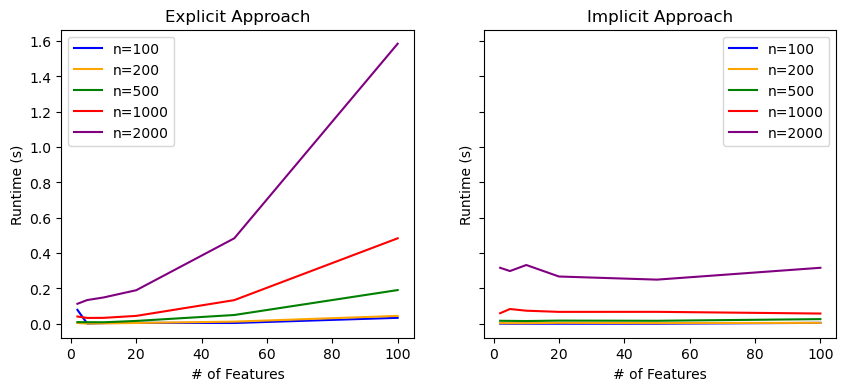

In [ ]:
import time

# vary the dataset sizes
N_SAMPLES = [100, 200, 500, 1000, 2000] 
N_FEATURES = [2, 5, 10, 20, 50, 100]

# FOR storing the timing results
timing_results = {
    'n_samples': [],
    'n_features': [],
    'explicit': [],
    'implicit': []
}

k = len(N_FEATURES)
colors = ['blue','orange','green', 'red','purple']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
feature_time = [0]*k
kernel_time = [0]*k

for i in range(len(N_SAMPLES)): 
    n = N_SAMPLES[i]
    for j in range(k): 
        num_feat = N_FEATURES[j]
        [data_xs, labels_ys] = generate_nested_hyperspheres(n, num_feat)
        
        # Runtime of explicit approach
        start = time.time()
        M = feature_map(data_xs)
        np.dot(M, M.T)
        end = time.time()
        diff = end-start
        feature_time[j] = diff
        
        # Runtime of Implicit approach
        start2 = time.time()
        kernel(data_xs)
        end2 = time.time()
        diff2 = end2-start2
        kernel_time[j] = diff2
        
        timing_results['n_samples'].append(n)
        timing_results['n_features'].append(num_feat)
        timing_results['explicit'].append(diff)
        timing_results['implicit'].append(diff2)
        
    ax1.plot(N_FEATURES, feature_time, label=f'n={n}', color=colors[i])
    ax2.plot(N_FEATURES, kernel_time, label=f'n={n}', color=colors[i])

# Label plots
ax1.set_title('Explicit Approach')
ax1.set_xlabel('# of Features')
ax1.set_ylabel('Runtime (s)')
ax1.legend()
ax2.set_title('Implicit Approach')
ax2.set_xlabel('# of Features')
ax2.set_ylabel('Runtime (s)')
ax2.legend()